## Wavelet Resampling
### Author: Zhizheng Wang

In [3]:
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Define file paths
train_csv = "/content/drive/MyDrive/Colab_Notebooks/dataset/train.csv"
test_csv = "/content/drive/MyDrive/Colab_Notebooks/dataset/test.csv"

# Load CSV files
train = pd.read_csv(train_csv, usecols=["image_ID", "label"])
test = pd.read_csv(test_csv, usecols=["image_ID"])

# Display shapes of train and test datasets
print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (8227, 2)
Test shape: (2056, 1)


In [ ]:
image_to_label_map = dict(zip(train["image_ID"].values, train["label"].values))

unique_classes = train["label"].unique()
print("Unique classes:", unique_classes)
print("Number of unique classes:", len(unique_classes))

Unique classes: ['Badminton' 'Cricket' 'Tennis' 'Swimming' 'Soccer' 'Wrestling' 'Karate']
Number of unique classes: 7


<Axes: xlabel='label', ylabel='count'>

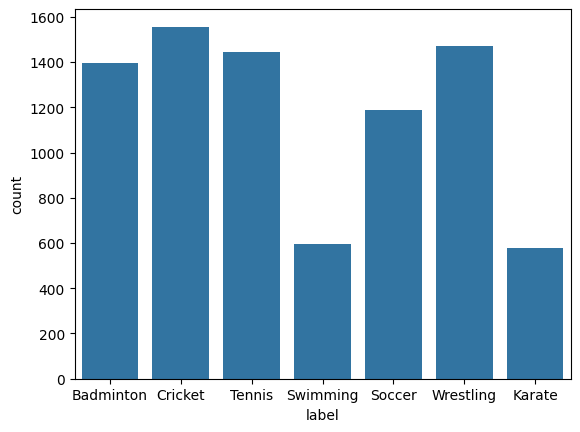

In [ ]:
import seaborn as sns

sns.countplot(data=train, x="label")

In [ ]:
label_counts = train["label"].value_counts()
print(label_counts)

label
Cricket      1556
Wrestling    1471
Tennis       1445
Badminton    1394
Soccer       1188
Swimming      595
Karate        578
Name: count, dtype: int64


## Resnet50

In [ ]:
from PIL import Image
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from torch.amp import GradScaler, autocast
from tqdm import tqdm

# Resnet50
# Dataset class for loading images and labels
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, is_test=False):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)

        if self.is_test or "label" not in self.dataframe.columns:
            return image  # No label available for test data
        label = torch.tensor(self.dataframe.iloc[idx, 1], dtype=torch.long)
        return image, label


In [ ]:
# 2. Split Data into Train and Validation Sets
train['label'] = pd.Categorical(train['label']).codes
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)  # 80-20 split

# 3. Define Image Transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 4. Define Image Directory Paths
train_img_dir = "/content/drive/MyDrive/Colab_Notebooks/dataset/train/"
test_img_dir = "/content/drive/MyDrive/Colab_Notebooks/dataset/test/"

# 5. Create Datasets and Dataloaders
train_dataset = CustomImageDataset(train_df, train_img_dir, transform=transform)
val_dataset = CustomImageDataset(val_df, train_img_dir, transform=transform)  # Same dir if validation images are in `train`
test_dataset = CustomImageDataset(test, test_img_dir, transform=transform, is_test=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# 6. Model Setup
num_classes = len(train["label"].unique())
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjusting last layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 7. Loss Function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

In [ ]:
# Initialize GradScaler with updated syntax
scaler = GradScaler()

num_epochs = 5  # Set number of epochs

# Initialize lists to store metrics for each epoch
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate accuracy and loss for the training epoch
    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    # Calculate accuracy and loss for the validation epoch
    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_model.pth")
        print("Model saved!")

# End of training
print("Training completed.")

Start training...


Epoch 1/5 - Training: 100%|██████████| 206/206 [22:31<00:00,  6.56s/it]


Epoch [1/5], Training Loss: 1.0677, Training Accuracy: 0.6251


Epoch 1/5 - Validation: 100%|██████████| 52/52 [05:30<00:00,  6.35s/it]


Epoch [1/5], Validation Loss: 0.9026, Validation Accuracy: 0.7072


Epoch 2/5 - Training: 100%|██████████| 206/206 [01:50<00:00,  1.86it/s]


Epoch [2/5], Training Loss: 0.6925, Training Accuracy: 0.7675


Epoch 2/5 - Validation: 100%|██████████| 52/52 [00:22<00:00,  2.35it/s]


Epoch [2/5], Validation Loss: 0.6129, Validation Accuracy: 0.7934


Epoch 3/5 - Training: 100%|██████████| 206/206 [01:44<00:00,  1.97it/s]


Epoch [3/5], Training Loss: 0.5417, Training Accuracy: 0.8136


Epoch 3/5 - Validation: 100%|██████████| 52/52 [00:24<00:00,  2.11it/s]


Epoch [3/5], Validation Loss: 0.5776, Validation Accuracy: 0.7983


Epoch 4/5 - Training: 100%|██████████| 206/206 [01:26<00:00,  2.37it/s]


Epoch [4/5], Training Loss: 0.4309, Training Accuracy: 0.8532


Epoch 4/5 - Validation: 100%|██████████| 52/52 [00:20<00:00,  2.57it/s]


Epoch [4/5], Validation Loss: 0.6169, Validation Accuracy: 0.7934


Epoch 5/5 - Training: 100%|██████████| 206/206 [01:24<00:00,  2.43it/s]


Epoch [5/5], Training Loss: 0.3343, Training Accuracy: 0.8847


Epoch 5/5 - Validation: 100%|██████████| 52/52 [00:18<00:00,  2.77it/s]

Epoch [5/5], Validation Loss: 0.5033, Validation Accuracy: 0.8323
Training completed.


Epoch [5/5], Training Loss: 0.3478, Training Accuracy: 0.8865


## VGG

In [ ]:
# VGG

num_classes = len(train["label"].unique())

# Load VGG16 with pre-trained weights and modify the classifier layer
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Adjust the final layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 7. Define Loss Function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Initialize GradScaler for mixed precision training
scaler = GradScaler()

num_epochs = 5  # Set the number of epochs
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with VGG16...")

# 8. Training Loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_vgg16_model.pth")
        print("Model saved!")

print("Training with VGG16 completed.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 71.5MB/s]


Start training with VGG16...


Epoch 1/5 - Training:   0%|          | 0/206 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/5 - Training: 100%|██████████| 206/206 [01:25<00:00,  2.40it/s]


Epoch [1/5], Training Loss: 1.9168, Training Accuracy: 0.2059


Epoch 1/5 - Validation: 100%|██████████| 52/52 [00:19<00:00,  2.72it/s]


Epoch [1/5], Validation Loss: 1.7993, Validation Accuracy: 0.2254


Epoch 2/5 - Training: 100%|██████████| 206/206 [01:25<00:00,  2.41it/s]


Epoch [2/5], Training Loss: 1.6814, Training Accuracy: 0.3027


Epoch 2/5 - Validation: 100%|██████████| 52/52 [00:19<00:00,  2.72it/s]


Epoch [2/5], Validation Loss: 1.5642, Validation Accuracy: 0.3761


Epoch 3/5 - Training: 100%|██████████| 206/206 [01:25<00:00,  2.41it/s]


Epoch [3/5], Training Loss: 1.5843, Training Accuracy: 0.3641


Epoch 3/5 - Validation: 100%|██████████| 52/52 [00:22<00:00,  2.32it/s]


Epoch [3/5], Validation Loss: 1.5594, Validation Accuracy: 0.3937


Epoch 4/5 - Training: 100%|██████████| 206/206 [01:39<00:00,  2.07it/s]


Epoch [4/5], Training Loss: 1.5266, Training Accuracy: 0.3867


Epoch 4/5 - Validation: 100%|██████████| 52/52 [00:21<00:00,  2.46it/s]


Epoch [4/5], Validation Loss: 1.4173, Validation Accuracy: 0.4277


Epoch 5/5 - Training: 100%|██████████| 206/206 [01:39<00:00,  2.07it/s]


Epoch [5/5], Training Loss: 1.4185, Training Accuracy: 0.4525


Epoch 5/5 - Validation: 100%|██████████| 52/52 [00:20<00:00,  2.53it/s]

Epoch [5/5], Validation Loss: 1.3322, Validation Accuracy: 0.5049
Training with VGG16 completed.


## GoogleNet

In [ ]:
num_classes = len(train["label"].unique())

# Load GoogLeNet with pre-trained weights and modify the final layer
model = models.googlenet(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust final fully connected layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler()  # Mixed precision training

# Training loop remains the same as in your existing code
num_epochs = 5
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with GoogLeNet...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_googlenet_model.pth")
        print("Model saved!")

print("Training with GoogLeNet completed.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 98.0MB/s]


Start training with GoogLeNet...


Epoch 1/5 - Training: 100%|██████████| 206/206 [01:45<00:00,  1.95it/s]


Epoch [1/5], Training Loss: 0.6411, Training Accuracy: 0.7856


Epoch 1/5 - Validation: 100%|██████████| 52/52 [00:20<00:00,  2.59it/s]


Epoch [1/5], Validation Loss: 0.6092, Validation Accuracy: 0.7989


Epoch 2/5 - Training: 100%|██████████| 206/206 [01:36<00:00,  2.14it/s]


Epoch [2/5], Training Loss: 0.3414, Training Accuracy: 0.8865


Epoch 2/5 - Validation: 100%|██████████| 52/52 [00:22<00:00,  2.35it/s]


Epoch [2/5], Validation Loss: 0.5052, Validation Accuracy: 0.8372


Epoch 3/5 - Training: 100%|██████████| 206/206 [01:25<00:00,  2.42it/s]


Epoch [3/5], Training Loss: 0.2751, Training Accuracy: 0.9067


Epoch 3/5 - Validation: 100%|██████████| 52/52 [00:23<00:00,  2.21it/s]


Epoch [3/5], Validation Loss: 0.4796, Validation Accuracy: 0.8524


Epoch 4/5 - Training: 100%|██████████| 206/206 [01:19<00:00,  2.59it/s]


Epoch [4/5], Training Loss: 0.2029, Training Accuracy: 0.9339


Epoch 4/5 - Validation: 100%|██████████| 52/52 [00:17<00:00,  2.93it/s]


Epoch [4/5], Validation Loss: 0.3192, Validation Accuracy: 0.8870


Epoch 5/5 - Training: 100%|██████████| 206/206 [01:20<00:00,  2.56it/s]


Epoch [5/5], Training Loss: 0.1304, Training Accuracy: 0.9576


Epoch 5/5 - Validation: 100%|██████████| 52/52 [00:17<00:00,  2.91it/s]

Epoch [5/5], Validation Loss: 0.3783, Validation Accuracy: 0.8791
Training with GoogLeNet completed.


## AlexNet

In [ ]:
# AlexNet

# Set the number of classes for the final layer
num_classes = len(train["label"].unique())

# Load AlexNet with pre-trained weights and adjust the classifier for the number of classes
model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Modify final fully connected layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler()  # For mixed precision training

# Initialize lists to store metrics
num_epochs = 5
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with AlexNet...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate accuracy and loss for the training epoch
    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_alexnet_model.pth")
        print("Model saved!")

print("Training with AlexNet completed.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 176MB/s]


Start training with AlexNet...


Epoch 1/5 - Training: 100%|██████████| 206/206 [01:13<00:00,  2.79it/s]


Epoch [1/5], Training Loss: 1.9402, Training Accuracy: 0.1924


Epoch 1/5 - Validation: 100%|██████████| 52/52 [00:17<00:00,  3.05it/s]


Epoch [1/5], Validation Loss: 1.8975, Validation Accuracy: 0.1701


Epoch 2/5 - Training: 100%|██████████| 206/206 [01:15<00:00,  2.71it/s]


Epoch [2/5], Training Loss: 1.8906, Training Accuracy: 0.1778


Epoch 2/5 - Validation: 100%|██████████| 52/52 [00:17<00:00,  3.03it/s]


Epoch [2/5], Validation Loss: 1.8850, Validation Accuracy: 0.1847


Epoch 3/5 - Training: 100%|██████████| 206/206 [01:13<00:00,  2.81it/s]


Epoch [3/5], Training Loss: 1.8879, Training Accuracy: 0.1814


Epoch 3/5 - Validation: 100%|██████████| 52/52 [00:17<00:00,  3.00it/s]


Epoch [3/5], Validation Loss: 1.8861, Validation Accuracy: 0.1847


Epoch 4/5 - Training: 100%|██████████| 206/206 [01:13<00:00,  2.80it/s]


Epoch [4/5], Training Loss: 1.8897, Training Accuracy: 0.1833


Epoch 4/5 - Validation: 100%|██████████| 52/52 [00:17<00:00,  2.99it/s]


Epoch [4/5], Validation Loss: 1.8871, Validation Accuracy: 0.1744


Epoch 5/5 - Training: 100%|██████████| 206/206 [01:13<00:00,  2.79it/s]


Epoch [5/5], Training Loss: 1.8889, Training Accuracy: 0.1816


Epoch 5/5 - Validation: 100%|██████████| 52/52 [00:17<00:00,  3.00it/s]

Epoch [5/5], Validation Loss: 1.8870, Validation Accuracy: 0.1847
Training with AlexNet completed.


Epoch [5/5], Training Loss: 1.8894, Training Accuracy: 0.1887 -> AlexNet  
Epoch [5/5], Training Loss: 0.1740, Training Accuracy: 0.9418-> googlenet  
Epoch [5/5], Training Loss: 1.1477, Training Accuracy: 0.5821 -> VGG16  
Epoch [5/5], Training Loss: 0.3478, Training Accuracy: 0.8800 -> Resnet50  

The dataset is probably very high in variability of features, moderately to greatly large in size with a great number of classes, and high-resolution images. The better performance by GoogLeNet and ResNet50 hints at complex and subtle patterns within the dataset that simpler models like AlexNet can't match.  

The dataset size is probably moderate to large: usually, the deeper models, like GoogLeNet and ResNet50, perform better when they have more data, which improves when using pre-trained weights. Similarly, the number of classes is probably big because, in this case, models like GoogLeNet handle the diversity among classes well, whereas AlexNet usually suffers in the multi-class environment.  

Finally, the dataset most likely contains high-resolution images (224x224 pixels or larger), as GoogLeNet and ResNet50 rely on detailed spatial information to distinguish complex features; this resolution allows deeper models to capture class-specific details—suggesting that GoogLeNet and ResNet50 would really be among the best choices for this dataset.  



# Upsample

In [4]:
# Define file paths
train_csv = "/content/drive/MyDrive/Colab_Notebooks/dataset/train_upsample.csv"
test_csv = "/content/drive/MyDrive/Colab_Notebooks/dataset/test.csv"

# Load CSV files
train = pd.read_csv(train_csv, usecols=["image_ID", "label"])
test = pd.read_csv(test_csv, usecols=["image_ID"])

# Display shapes of train and test datasets
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (10892, 2)
Test shape: (2056, 1)


In [6]:
image_to_label_map = dict(zip(train["image_ID"].values, train["label"].values))

unique_classes = train["label"].unique()
print("Unique classes:", unique_classes)
print("Number of unique classes:", len(unique_classes))

Unique classes: ['Swimming' 'Cricket' 'Soccer' 'Wrestling' 'Tennis' 'Karate' 'Badminton']
Number of unique classes: 7


<Axes: xlabel='label', ylabel='count'>

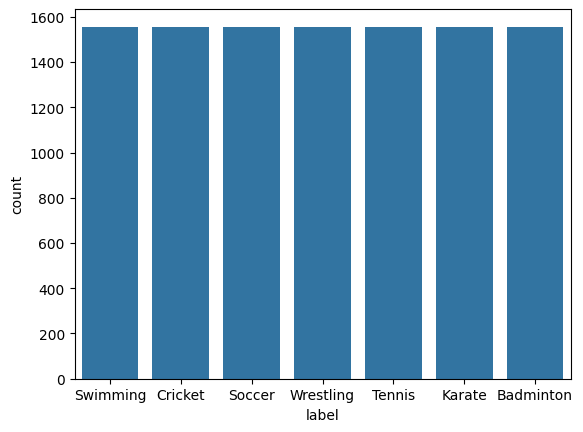

In [5]:
import seaborn as sns

sns.countplot(data=train, x="label")

In [7]:
label_counts = train["label"].value_counts()
print(label_counts)

label
Swimming     1556
Cricket      1556
Soccer       1556
Wrestling    1556
Tennis       1556
Karate       1556
Badminton    1556
Name: count, dtype: int64


## Resnet50 - Upsample

In [8]:
from PIL import Image
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from torch.amp import GradScaler, autocast
from tqdm import tqdm

# Resnet50
# Dataset class for loading images and labels
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, is_test=False):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)

        if self.is_test or "label" not in self.dataframe.columns:
            return image  # No label available for test data
        label = torch.tensor(self.dataframe.iloc[idx, 1], dtype=torch.long)
        return image, label


In [9]:
# 2. Split Data into Train and Validation Sets
train['label'] = pd.Categorical(train['label']).codes
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)  # 80-20 split

# 3. Define Image Transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 4. Define Image Directory Paths
train_img_dir = "/content/drive/MyDrive/Colab_Notebooks/dataset/upsampled/"
test_img_dir = "/content/drive/MyDrive/Colab_Notebooks/dataset/test/"

# 5. Create Datasets and Dataloaders
train_dataset = CustomImageDataset(train_df, train_img_dir, transform=transform)
val_dataset = CustomImageDataset(val_df, train_img_dir, transform=transform)  # Same dir if validation images are in `train`
test_dataset = CustomImageDataset(test, test_img_dir, transform=transform, is_test=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# 6. Model Setup
num_classes = len(train["label"].unique())
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjusting last layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 7. Loss Function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 211MB/s]


In [ ]:
# Initialize GradScaler with updated syntax
scaler = GradScaler()

num_epochs = 5  # Set number of epochs

# Initialize lists to store metrics for each epoch
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate accuracy and loss for the training epoch
    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    # Calculate accuracy and loss for the validation epoch
    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_model.pth")
        print("Model saved!")

# End of training
print("Training completed.")

Start training...


Epoch 1/5 - Training: 100%|██████████| 273/273 [31:51<00:00,  7.00s/it]


Epoch [1/5], Training Loss: 1.1491, Training Accuracy: 0.6068


Epoch 1/5 - Validation: 100%|██████████| 69/69 [07:52<00:00,  6.85s/it]


Epoch [1/5], Validation Loss: 1.0207, Validation Accuracy: 0.6696


Epoch 2/5 - Training: 100%|██████████| 273/273 [00:30<00:00,  9.01it/s]


Epoch [2/5], Training Loss: 0.8098, Training Accuracy: 0.7248


Epoch 2/5 - Validation: 100%|██████████| 69/69 [00:07<00:00,  9.42it/s]


Epoch [2/5], Validation Loss: 0.7773, Validation Accuracy: 0.7260


Epoch 3/5 - Training: 100%|██████████| 273/273 [00:30<00:00,  9.03it/s]


Epoch [3/5], Training Loss: 0.6512, Training Accuracy: 0.7800


Epoch 3/5 - Validation: 100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Epoch [3/5], Validation Loss: 0.5958, Validation Accuracy: 0.8063


Epoch 4/5 - Training: 100%|██████████| 273/273 [00:30<00:00,  8.95it/s]


Epoch [4/5], Training Loss: 0.5168, Training Accuracy: 0.8234


Epoch 4/5 - Validation: 100%|██████████| 69/69 [00:07<00:00,  9.50it/s]


Epoch [4/5], Validation Loss: 0.5531, Validation Accuracy: 0.8219


Epoch 5/5 - Training: 100%|██████████| 273/273 [00:29<00:00,  9.11it/s]


Epoch [5/5], Training Loss: 0.4076, Training Accuracy: 0.8608


Epoch 5/5 - Validation: 100%|██████████| 69/69 [00:07<00:00,  9.48it/s]

Epoch [5/5], Validation Loss: 0.6456, Validation Accuracy: 0.8036
Training completed.


## VGG - Upsample

In [ ]:
# VGG

num_classes = len(train["label"].unique())

# Load VGG16 with pre-trained weights and modify the classifier layer
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Adjust the final layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 7. Define Loss Function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Initialize GradScaler for mixed precision training
scaler = GradScaler()

num_epochs = 5  # Set the number of epochs
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with VGG16...")

# 8. Training Loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_vgg16_model.pth")
        print("Model saved!")

print("Training with VGG16 completed.")

Start training with VGG16...


Epoch 1/5 - Training: 100%|██████████| 273/273 [00:29<00:00,  9.26it/s]


Epoch [1/5], Training Loss: 1.7784, Training Accuracy: 0.2691


Epoch 1/5 - Validation: 100%|██████████| 69/69 [00:07<00:00,  9.56it/s]


Epoch [1/5], Validation Loss: 1.5090, Validation Accuracy: 0.3786


Epoch 2/5 - Training: 100%|██████████| 273/273 [00:29<00:00,  9.25it/s]


Epoch [2/5], Training Loss: 1.6377, Training Accuracy: 0.3344


Epoch 2/5 - Validation: 100%|██████████| 69/69 [00:07<00:00,  9.50it/s]


Epoch [2/5], Validation Loss: 1.5472, Validation Accuracy: 0.3786


Epoch 3/5 - Training: 100%|██████████| 273/273 [00:29<00:00,  9.32it/s]


Epoch [3/5], Training Loss: 1.5480, Training Accuracy: 0.3917


Epoch 3/5 - Validation: 100%|██████████| 69/69 [00:07<00:00,  9.13it/s]


Epoch [3/5], Validation Loss: 1.5035, Validation Accuracy: 0.4493


Epoch 4/5 - Training: 100%|██████████| 273/273 [00:29<00:00,  9.36it/s]


Epoch [4/5], Training Loss: 1.4884, Training Accuracy: 0.4210


Epoch 4/5 - Validation: 100%|██████████| 69/69 [00:07<00:00,  9.15it/s]


Epoch [4/5], Validation Loss: 1.3551, Validation Accuracy: 0.5145


Epoch 5/5 - Training: 100%|██████████| 273/273 [00:29<00:00,  9.31it/s]


Epoch [5/5], Training Loss: 1.4080, Training Accuracy: 0.4694


Epoch 5/5 - Validation: 100%|██████████| 69/69 [00:07<00:00,  9.49it/s]

Epoch [5/5], Validation Loss: 1.3464, Validation Accuracy: 0.5145
Training with VGG16 completed.


## GoogleNet - Upsample

In [10]:
num_classes = len(train["label"].unique())

# Load GoogLeNet with pre-trained weights and modify the final layer
model = models.googlenet(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust final fully connected layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler()  # Mixed precision training

# Training loop remains the same as in your existing code
num_epochs = 5
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with GoogLeNet...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_googlenet_model.pth")
        print("Model saved!")

print("Training with GoogLeNet completed.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 207MB/s]


Start training with GoogLeNet...


Epoch 1/5 - Training: 100%|██████████| 273/273 [30:31<00:00,  6.71s/it]


Epoch [1/5], Training Loss: 0.7493, Training Accuracy: 0.7414


Epoch 1/5 - Validation: 100%|██████████| 69/69 [07:26<00:00,  6.48s/it]


Epoch [1/5], Validation Loss: 0.5426, Validation Accuracy: 0.8201


Epoch 2/5 - Training: 100%|██████████| 273/273 [00:29<00:00,  9.13it/s]


Epoch [2/5], Training Loss: 0.4634, Training Accuracy: 0.8440


Epoch 2/5 - Validation: 100%|██████████| 69/69 [00:07<00:00,  9.52it/s]


Epoch [2/5], Validation Loss: 0.5095, Validation Accuracy: 0.8274


Epoch 3/5 - Training: 100%|██████████| 273/273 [00:30<00:00,  8.90it/s]


Epoch [3/5], Training Loss: 0.3457, Training Accuracy: 0.8853


Epoch 3/5 - Validation: 100%|██████████| 69/69 [00:07<00:00,  9.33it/s]


Epoch [3/5], Validation Loss: 0.4626, Validation Accuracy: 0.8541


Epoch 4/5 - Training: 100%|██████████| 273/273 [00:30<00:00,  9.08it/s]


Epoch [4/5], Training Loss: 0.2737, Training Accuracy: 0.9073


Epoch 4/5 - Validation: 100%|██████████| 69/69 [00:07<00:00,  9.19it/s]


Epoch [4/5], Validation Loss: 0.4420, Validation Accuracy: 0.8614


Epoch 5/5 - Training: 100%|██████████| 273/273 [00:30<00:00,  8.99it/s]


Epoch [5/5], Training Loss: 0.2000, Training Accuracy: 0.9348


Epoch 5/5 - Validation: 100%|██████████| 69/69 [00:07<00:00,  9.16it/s]

Epoch [5/5], Validation Loss: 0.5509, Validation Accuracy: 0.8261
Training with GoogLeNet completed.


## AlexNet

In [ ]:
# AlexNet

# Set the number of classes for the final layer
num_classes = len(train["label"].unique())

# Load AlexNet with pre-trained weights and adjust the classifier for the number of classes
model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Modify final fully connected layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler()  # For mixed precision training

# Initialize lists to store metrics
num_epochs = 5
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with AlexNet...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate accuracy and loss for the training epoch
    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_alexnet_model.pth")
        print("Model saved!")

print("Training with AlexNet completed.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 220MB/s]


Start training with AlexNet...


Epoch 1/5 - Training: 100%|██████████| 273/273 [00:29<00:00,  9.30it/s]


Epoch [1/5], Training Loss: 1.9622, Training Accuracy: 0.1513


Epoch 1/5 - Validation: 100%|██████████| 69/69 [00:07<00:00,  9.51it/s]


Epoch [1/5], Validation Loss: 1.9460, Validation Accuracy: 0.1459


Epoch 2/5 - Training: 100%|██████████| 273/273 [00:28<00:00,  9.54it/s]


Epoch [2/5], Training Loss: 1.9467, Training Accuracy: 0.1440


Epoch 2/5 - Validation: 100%|██████████| 69/69 [00:07<00:00,  9.81it/s]


Epoch [2/5], Validation Loss: 1.9470, Validation Accuracy: 0.1459


Epoch 3/5 - Training: 100%|██████████| 273/273 [00:29<00:00,  9.24it/s]


Epoch [3/5], Training Loss: 1.9474, Training Accuracy: 0.1458


Epoch 3/5 - Validation: 100%|██████████| 69/69 [00:07<00:00,  9.78it/s]


Epoch [3/5], Validation Loss: 1.9461, Validation Accuracy: 0.1436


Epoch 4/5 - Training: 100%|██████████| 273/273 [00:29<00:00,  9.39it/s]


Epoch [4/5], Training Loss: 1.9467, Training Accuracy: 0.1456


Epoch 4/5 - Validation: 100%|██████████| 69/69 [00:07<00:00,  9.41it/s]


Epoch [4/5], Validation Loss: 1.9502, Validation Accuracy: 0.1441


Epoch 5/5 - Training: 100%|██████████| 273/273 [00:28<00:00,  9.62it/s]


Epoch [5/5], Training Loss: 1.9471, Training Accuracy: 0.1414


Epoch 5/5 - Validation: 100%|██████████| 69/69 [00:07<00:00,  9.71it/s]

Epoch [5/5], Validation Loss: 1.9506, Validation Accuracy: 0.1335
Training with AlexNet completed.
